In [1]:
import warnings
warnings.filterwarnings("ignore")

import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import squidpy as sq
import math
import SpaGCN as spg
from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
#In order to read in image data, we need to install some package. Here we recommend package "opencv"
#inatll opencv in python
import cv2

In [2]:
from scanpy import read_10x_h5

# proj_list = ['151507']
ARI_list,AMI_list = [],[]

# adata = sq.datasets.slideseqv2() # 4000高变基因
# adata.var_names_make_unique() 
# adata = adata[(adata.obs["x"]>=1000) & (adata.obs["x"]<=5600) & (adata.obs["y"]<=5400) & (adata.obs["y"]>=2600)]
adata = read_10x_h5("/home/tengliu/Torch_pyG/Breast_cancer_comparison/SPGDL/data/V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix.h5")
spatial=pd.read_csv("/home/tengliu/Torch_pyG/Breast_cancer_comparison/SPGDL/data/spatial/tissue_positions_list.csv",sep=",",header=None,na_filter=False,index_col=0) 

adata.obs["x1"]=spatial[1]
adata.obs["x2"]=spatial[2]
adata.obs["x3"]=spatial[3]
adata.obs["x4"]=spatial[4]
adata.obs["x5"]=spatial[5]
adata.obs["x_array"]=adata.obs["x2"]
adata.obs["y_array"]=adata.obs["x3"]
adata.obs["x_pixel"]=adata.obs["x4"]
adata.obs["y_pixel"]=adata.obs["x5"]
#Select captured samples
adata=adata[adata.obs["x1"]==1]
adata.var_names=[i.upper() for i in list(adata.var_names)]
adata.var["genename"]=adata.var.index.astype("str")
img=cv2.imread("/home/tengliu/Torch_pyG/Breast_cancer_comparison/SPGDL/data/V1_Breast_Cancer_Block_A_Section_1_image.tif")
#Set coordinates
x_array=adata.obs["x_array"].tolist()
y_array=adata.obs["y_array"].tolist()
x_pixel=adata.obs["x_pixel"].tolist()
y_pixel=adata.obs["y_pixel"].tolist()

#Test coordinates on the image
img_new=img.copy()
for i in range(len(x_pixel)):
    x=x_pixel[i]
    y=y_pixel[i]
    img_new[int(x-20):int(x+20), int(y-20):int(y+20),:]=0

#Calculate adjacent matrix
s=1
b=49
adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, x_pixel=x_pixel, y_pixel=y_pixel, image=img, beta=b, alpha=s, histology=True)
#If histlogy image is not available, SpaGCN can calculate the adjacent matrix using the fnction below
#adj=calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)

#Normalization
adata.var_names_make_unique()
spg.prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

p=0.5 
#Find the l value given p
l=spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)


n_clusters = 20
#Set seed
r_seed=t_seed=n_seed=100
#Seaech for suitable resolution
res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

clf=spg.SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
y_pred, prob=clf.predict()
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')

# load ground truth read the annotation  
df_meta = pd.read_csv('/home/tengliu/Torch_pyG/Breast_cancer_comparison/SPGDL/data/metadata.tsv', sep='\t',index_col=0)
# index_col = 0 能够去掉dataframe最左边的序号列。
df_meta = df_meta.drop(columns=['annot_type'])
df_meta.columns = ['Ground Truth']
adata.obs['Ground Truth'] = df_meta.loc[adata.obs_names, 'Ground Truth']

from sklearn import metrics
obs_df = adata.obs.dropna() ##过滤掉缺失值的行，即当前分类值为Nan，就把该行过滤掉。
ARI = metrics.adjusted_rand_score(obs_df['pred'], obs_df['Ground Truth']) ## ARI 是从 包sklearn.metrics.cluster中导入的衡量标准
AMI = metrics.adjusted_mutual_info_score(obs_df['pred'], obs_df['Ground Truth'])

print('Adjusted rand index = %.2f' %ARI)
adata.uns["ARI"] = ARI
adata.uns["AMI"] = AMI

ARI_list.append(ARI)
AMI_list.append(AMI)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.pca(adata,n_comps=30)
sc.pp.neighbors(adata)
# sc.pp.neighbors(adata, use_rep='STAGATE',n_neighbors=250,n_pcs=30,knn=True,method="umap") 
# ## STAGATE为训练出来的embeddings, 然后用它进行下游的分析。
sc.tl.umap(adata) ## 利用neighbors计算降维图Umap.

adata_filename = "Human_Cancer"+"_spaGCN"+".h5ad"
adata.filename = './Results/'+adata_filename

Metrics_spaGCN = pd.DataFrame([ARI_list,AMI_list])
Metrics_spaGCN.to_csv("./Results/Metrics_spaGCN .csv")

Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  52.33422402591216 452.05073100505365 383.2752180620786
Var of x,y,z =  24797174.29576617 19094839.07201879 24797174.29576618
Run 1: l [0.01, 1000], p [0.0, 15.934320444063161]
Run 2: l [0.01, 500.005], p [0.0, 2.301516056060791]
Run 3: l [250.0075, 500.005], p [0.2730879783630371, 2.301516056060791]
Run 4: l [250.0075, 375.00625], p [0.2730879783630371, 0.9840335845947266]
Run 5: l [250.0075, 312.50687500000004], p [0.2730879783630371, 0.5618032217025757]
Run 6: l [281.2571875, 312.50687500000004], p [0.40192973613739014, 0.5618032217025757]
Run 7: l [296.88203125, 312.50687500000004], p [0.477838397026062, 0.5618032217025757]
Run 8: l [296.88203125, 304.694453125], p [0.477838397026062, 0.5187956094741821]
recommended l =  300.78824218750003
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7


2022-11-20 16:55:13.625092: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 16:55:13.724954: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-20 16:55:13.742439: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-20 16:55:14.005543: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  10
Initializing cluster centers with louvain, resolution =  0.7999999999999999
Epoch  0
Epoch  10
delta_label  0.00421274354923644 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 19
Res =  0.7999999999999999 Num of clusters =  12
Res changed to 0.7999999999999999
Initializing cluster centers with louvain, resolution =  0.8999999999999999
Epoch  0
Epoch  10
Res =  0.8999999999999999 Num of clusters =  13
Res changed to 0.8999999999999999
Initializing cluster centers with louvain, resolution =  0.9999999999999999
Epoch  0
Epoch  10
Res =  0.9999999999999999 Num of clusters =  15
Res changed to 0.9999999999999999
Initializing cluster centers with louvain, resolution =  1.0999999999999999
Epoch  0
Epoch  10
Res =  1.0999999999999999 Num of clusters =  15
Res changed to 1.0999999999999999
Initializing cluster centers with louvain, resolution =  1.2
Epoch  0
Epoch  10
Res =  1.2 Num of clusters =  16
Res changed to 1.2


In [6]:
adata

AnnData object with n_obs × n_vars = 3798 × 22218 backed at 'Results/Human_Cancer_spaGCN.h5ad'
    obs: 'x1', 'x2', 'x3', 'x4', 'x5', 'x_array', 'y_array', 'x_pixel', 'y_pixel', 'n_counts', 'pred', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p', 'ARI', 'AMI', 'pca', 'neighbors', 'umap', 'pred_colors', 'Ground Truth_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

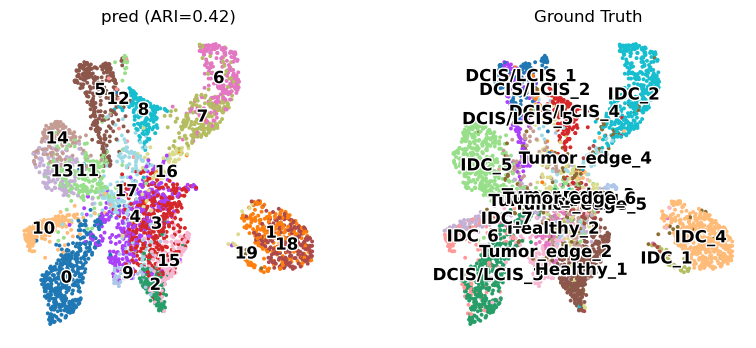

In [4]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=['pred', "Ground Truth"],legend_loc='on data', 
            legend_fontsize=12,legend_fontoutline=2,frameon=False, title=['pred' + ' (ARI=%.2f)'%ARI, "Ground Truth"])